In [1]:
import numpy as np
import scipy.signal as signal
import random
import cvxpy as cp
from helper import awgn, draw, draw_3d, hermitian, RMSE, findNMaxPeaks
import time
import matplotlib.pyplot as plt
import sys
epsilon = 1e-11

In [2]:
N = 0
M = 0
f = []
a = lambda f : np.array([ np.exp(-1j* i * 2 * np.pi * f ) for i in range(M) ], dtype=complex).reshape((M,1))

# signal model
def create_signal(snr, numSample, numArrElem, numFreq=None, freqs=None):
  global N,M,f,a
  N = numSample # number of samples
  M = numArrElem # number of arr elem
  f = []
  if (type(freqs) != type(None)):
    f = freqs
  else:
    intervals = np.linspace(0,1,numFreq+1)
    width = intervals[1]
    for k in range(len(intervals)):
      if (k==0):
        continue
      f.append(random.random() * (width) + (intervals[k-1]))
    f.sort()
  A = np.hstack([ a(ff) for ff in f ])
  s = lambda f : 2 * np.exp( 1j * f * np.array(range(N)).reshape((N,1)) )
  S = np.hstack([ s(ff) for ff in f ]).T
  X = A @ S
  # X = np.array([awgn(X[i], snr) for i  n range(M)])
  X = awgn(X, snr)
  return X
X = create_signal(100, numSample=500, numArrElem=25, numFreq=5)
print(X.shape)
# plt.xticks(np.array(range(M))+1)
# plt.xlabel("array element m")
# plt.ylabel("singal amplitude")
# plt.plot(list(range(M)), np.real(X[:,0]), label = "real")
# plt.plot(list(range(M)), np.imag(X[:,0]), label = "imag")
# plt.legend()
# plt.show()
# # draw(list(range(N)), np.real(X[0,:]), "time t", "real part of singal received by {}'th element".format(0+1), "Singal")
# # draw(list(range(N)), np.imag(X[0,:]), "time t", "imag part of singal received by {}'th element".format(0+1), "Singal")
# draw_3d(list(range(M)), np.real(X[:,0]), np.imag(X[:,0]), "t", "real part", "imag part")

(25, 500)


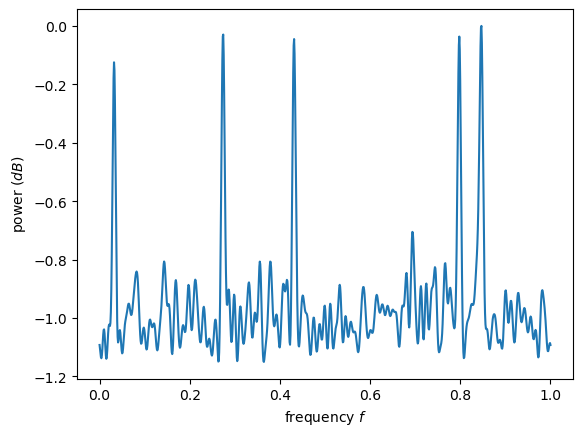

In [3]:
def MUSIC(X, numFreq, numSampling):
  Rxx = X @ hermitian(X)
  eigVal, eigVec = np.linalg.eigh(Rxx)
  NN = eigVec[:, 0:M-numFreq]
  Pmusic = []
  f_list = np.linspace(0,1,numSampling)
  for fx in f_list:
    Pmusic.append(1.0 / np.linalg.norm(hermitian(NN) @ a(fx))**2)
  pMax = np.max(Pmusic)
  Pmusic = np.real(10*np.log10(Pmusic/pMax))
  # Pmusic = np.real(Pmusic/pMax)
  return Pmusic

xx = np.linspace(0,1,1000)
X = create_signal(100, numSample=1, numArrElem=100, numFreq=5)
y = MUSIC(X,len(f), 1000)
draw(xx,y,"frequency $f$","power $(dB)$","")


In [4]:
peaks, props = signal.find_peaks(y)
print(f)
print(np.sort(xx[peaks[findNMaxPeaks(y,peaks,len(f))]]))
print(RMSE(np.sort(xx[peaks[findNMaxPeaks(y,peaks,len(f))]]),f))

[0.03228243097128063, 0.27391157338117805, 0.4314494076354281, 0.7979549419644983, 0.8460749005537634]
[0.03203203 0.27427427 0.43143143 0.7977978  0.84684685]
0.0004037747092310189


[[ 1.00000884e+01-5.64267204e-05j]
 [ 1.57115632e+00+3.41067268e-01j]
 [-1.12875396e+00+4.32316018e+00j]
 [-1.55195699e+00-2.02715963e+00j]
 [ 1.94423734e+00-3.80145226e+00j]
 [ 3.03412887e+00-6.68612690e+00j]
 [-2.08634302e-03+1.77004047e+00j]
 [ 4.07184765e+00+7.23578180e-01j]
 [-2.54649466e+00-3.81074757e+00j]
 [-1.64203749e+00-1.52681025e+00j]
 [-1.76464412e+00-1.86898296e+00j]
 [ 3.60350787e-01+3.52676372e-01j]
 [-1.73232541e+00-5.76786695e+00j]
 [-4.55655314e+00-3.72652181e-01j]
 [ 3.11530478e+00+5.20409940e-01j]
 [-1.16731013e+00+4.34818162e-01j]
 [-3.55687505e+00+2.45634721e+00j]
 [-7.34968065e+00+2.71625200e-03j]
 [-7.79084067e-01+3.13714530e-01j]
 [ 2.53885092e+00-5.11241766e+00j]
 [-8.83115680e-01+4.21711078e+00j]
 [ 1.31842074e+00+7.04273371e+00j]
 [-3.91208071e+00+3.49734063e+00j]
 [-2.08125299e+00-1.07454894e+00j]
 [-2.22263308e+00-2.21386644e+00j]
 [ 5.36036063e+00+4.45514215e+00j]
 [ 4.87116717e+00+3.74953845e-01j]
 [-2.19285041e+00+4.05212258e+00j]
 [ 5.91060876e-01+2.

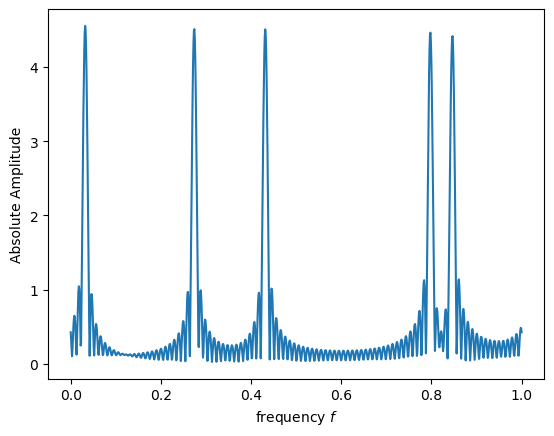

In [5]:
def ANM(x):
  c = cp.Constant(np.ones((1,1)))
  p = cp.Variable((M,1), complex=True)
  H = cp.Variable((M,M), complex=True)
  constraints = [ cp.bmat([
    [ H, p],
    [ p.H, c ]
  ]) >> 0 ]
  superDiagonal = lambda k : [ H[i,i+k] for i in range(M-k) ]
  delta = lambda k : 1 if (k == 0) else 1
  constraints += [ cp.sum(superDiagonal(k)) == delta(k) for k in range(M) ] 

  prob = cp.Problem(cp.Maximize( cp.real( cp.scalar_product(x,p) ) ), constraints)
  prob.solve()

  return p.value, H.value
  

def calcFreq(p,H,numSamples):
  graphX = np.linspace(0,1,numSamples)
  graphY = np.zeros((numSamples))
  for i in range(len(graphX)):
    tau = graphX[i]
    P = hermitian(a(tau)) @ p
    graphY[i] = np.sqrt(np.real(P)**2 + np.imag(P)**2)
  return graphX, graphY

print(X)
p, H = ANM(X[:,0].reshape(M,1))
graphX, graphY = calcFreq(p,H,1000)
draw(graphX, graphY, "frequency $f$", "Absolute Amplitude", "")

In [6]:
peaks, props = signal.find_peaks(graphY)
print(f)
print(np.sort(graphX[peaks[findNMaxPeaks(y,peaks,len(f))]]))
print(RMSE(graphX[np.sort(peaks[findNMaxPeaks(y,peaks,len(f))])],f))


[0.03228243097128063, 0.27391157338117805, 0.4314494076354281, 0.7979549419644983, 0.8460749005537634]
[0.03203203 0.27427427 0.43143143 0.7977978  0.84684685]
0.0004037747092310189


In [7]:
def test_speed(numSamples, numArrayElem, numFreqs=None, freqs=None):
  X = create_signal(100, numSample=numSamples, numArrElem=numArrayElem, numFreq=numFreqs) if type(freqs) == type(None) else create_signal(1, numSample=numSamples, numArrElem=numArrayElem, freqs=freqs)
  t0 = time.time()
  MUSIC(X, len(freqs) if type(numFreqs) == type(None) else numFreqs, 1000)
  t1 = time.time()
  print("MUSIC: {}s".format(t1-t0))
  t2 = time.time()
  p, H = ANM(X[:,0].reshape(M,1))
  calcFreq(p,H, 1000)
  t3 = time.time()
  print("ANM: {}s".format(t3-t2))
  return t1-t0, t3-t2
  

0.0 [0.2, 0.5, 0.8] [0.06006006 0.7967968  0.2032032 ] [0.06006006 0.7967968  0.2032032 ] 0.1894569308048614 0.1894569308048614
0.10020040080160321 [0.2, 0.5, 0.8] [0.48248248 0.17217217 0.78578579] [0.48248248 0.17217217 0.78578579] 0.020682482985361746 0.020682482985361746
0.20040080160320642 [0.2, 0.5, 0.8] [0.74174174 0.17417417 0.3993994 ] [0.74174174 0.17417417 0.3993994 ] 0.06875434235031601 0.06875434235031601
0.30060120240480964 [0.2, 0.5, 0.8] [0.8018018  0.21221221 0.47947948] [0.8018018  0.21221221 0.47947948] 0.01382601870004743 0.01382601870004743
0.40080160320641284 [0.2, 0.5, 0.8] [0.19219219 0.54154154 0.83583584] [0.19219219 0.54154154 0.83583584] 0.03199410709523585 0.03199410709523585
0.5010020040080161 [0.2, 0.5, 0.8] [0.7967968  0.04904905 0.5035035 ] [0.7967968  0.04904905 0.5035035 ] 0.08719465702391875 0.08719465702391875
0.6012024048096193 [0.2, 0.5, 0.8] [0.17717718 0.81281281 0.48748749] [0.17717718 0.81281281 0.48748749] 0.01674925255201879 0.01674925255201

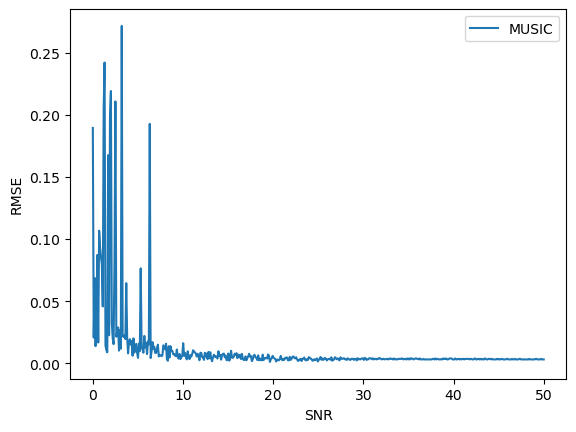

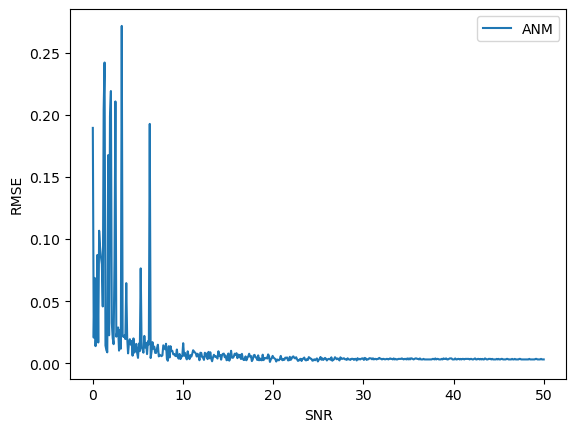

In [8]:
def test_error(k):
  X = create_signal(k,1,10,None,[0.2,0.5,0.8])
  freq = f
  yMusic = MUSIC(X, 1, 1000)
  p,H = ANM(X[:,0].reshape(M,1))
  graphX, graphY_ANM = calcFreq(p,H,1000)
  peaks_MUSIC, props = signal.find_peaks(yMusic)
  peaks_ANM, props = signal.find_peaks(graphY_ANM)
  peaks_MUSIC = peaks_MUSIC[findNMaxPeaks(yMusic, peaks_MUSIC, 3)]
  peaks_ANM = peaks_ANM[findNMaxPeaks(graphY_ANM, peaks_ANM, 3)]
  rmse1 = RMSE(np.sort(graphX[peaks_MUSIC]),freq)
  rmse2 = RMSE(np.sort(graphX[peaks_ANM]),freq)
  print(k, freq, graphX[peaks_MUSIC], graphX[peaks_ANM], rmse1, rmse2)
  return rmse1, rmse2

iterList = np.linspace(0,50,500)
rmse_MUSIC = []
rmse_ANM = []
for k in iterList:
  rmse1, rmse2 = test_error(k)
  rmse_MUSIC.append(rmse1)
  rmse_ANM.append(rmse2)
plt.xlabel("SNR")
plt.ylabel("RMSE")
plt.plot(iterList, rmse_MUSIC, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("SNR")
plt.ylabel("RMSE")
plt.plot(iterList, rmse_ANM, label = "ANM")
plt.legend()
plt.show()

[0.3, 0.31] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09822999370964414 0.09822999370964414 0 0
[0.3, 0.3101803607214429] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09823438638131628 0.09823438638131628 0 0
[0.3, 0.31036072144288573] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09823894442236533 0.09823894442236533 0 0
[0.3, 0.31054108216432863] [0.16116116 0.30530531] [0.16116116 0.30530531]
0.09824366780977424 0.09824366780977424 0 0
[0.3, 0.3107214428857715] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.09816721975668445 0.09816721975668445 0 0
[0.3, 0.3109018036072144] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.09803977874518047 0.09803977874518047 0 0
[0.3, 0.3110821643286573] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.0979123379765826 0.0979123379765826 0 0
[0.3, 0.3112625250501002] [0.30530531 0.44944945] [0.30530531 0.44944945]
0.09778489745184057 0.09778489745184057 0 0
[0.3, 0.31144288577154305] [0.30530531 0.44944945] [0.30530531 0.44944

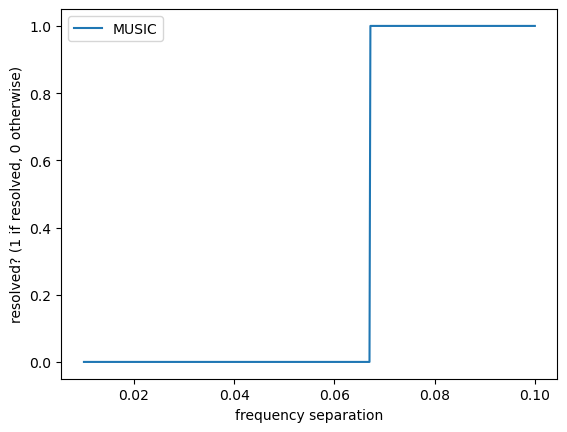

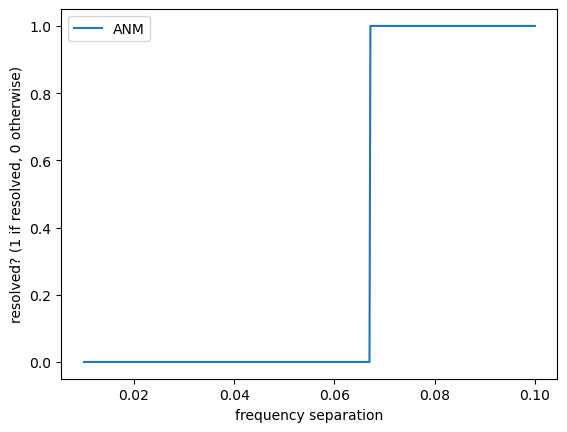

In [9]:
def test_superResolution(separation):
  X = create_signal(100,1,10,None,[0.3, 0.3+separation])
  freq = f
  yMusic = MUSIC(X, 1, 1000)
  p,H = ANM(X[:,0].reshape(M,1))
  graphX, graphY_ANM = calcFreq(p,H,1000)

  peaks_MUSIC, props = signal.find_peaks(yMusic)
  peaks_ANM, props = signal.find_peaks(graphY_ANM)
  peaks_MUSIC = peaks_MUSIC[findNMaxPeaks(yMusic, peaks_MUSIC, 2)]
  peaks_ANM = peaks_ANM[findNMaxPeaks(graphY_ANM, peaks_ANM, 2)]
  print(freq, np.sort(graphX[peaks_MUSIC]), np.sort(graphX[peaks_ANM]))
  # draw(graphX, yMusic, "", "", "")
  # draw(graphX, graphY_ANM, "", "", "")
  ret_MUSIC = 1 if RMSE(np.sort(graphX[peaks_MUSIC]), freq) < 0.05 else 0
  ret_ANM = 1 if RMSE(np.sort(graphX[peaks_ANM]), freq) < 0.05 else 0
  print(RMSE(np.sort(graphX[peaks_MUSIC]), freq),RMSE(np.sort(graphX[peaks_ANM]), freq), ret_MUSIC, ret_ANM)
  return ret_MUSIC, ret_ANM

# test_superResolution(0.01)
boolMUSIC = []
boolANM = []
iterList = np.linspace(0.01,0.1,500)
for separation in iterList:
  bool1, bool2 = test_superResolution(separation)
  boolMUSIC.append(bool1)
  boolANM.append(bool2)
plt.xlabel("frequency separation")
plt.ylabel("resolved? (1 if resolved, 0 otherwise)")
plt.plot(iterList, boolMUSIC, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("frequency separation")
plt.ylabel("resolved? (1 if resolved, 0 otherwise)")
plt.plot(iterList, boolANM, label = "ANM")
plt.legend()
plt.show()

In [10]:
bothResolved = False
oneResolved = False
for i in range(500):
  x = iterList[i]
  bool1 = boolMUSIC[i]
  bool2 = boolANM[i]
  if (bothResolved and oneResolved):
    break
  if (bool1 == 0 and bool2 == 0):
    continue
  elif (bool1 == 1 and bool2 == 1):
    if (not bothResolved):
      print('both resolved at x= ',x)
      bothResolved = True
  else:
    if (not oneResolved):
      print('{} resolved at x= {}'.format('MUSIC' if bool1 == 1 else 'ANM', x))
      oneResolved = True

both resolved at x=  0.06717434869739479


MUSIC: 0.01893758773803711s
ANM: 0.06429338455200195s
MUSIC: 0.013953208923339844s
ANM: 0.10715055465698242s
MUSIC: 0.01494908332824707s
ANM: 0.13405776023864746s
MUSIC: 0.015452861785888672s
ANM: 0.1392524242401123s
MUSIC: 0.016942977905273438s
ANM: 0.20309901237487793s
MUSIC: 0.019933223724365234s
ANM: 0.23461174964904785s
MUSIC: 0.019933462142944336s
ANM: 0.3205101490020752s
MUSIC: 0.021159648895263672s
ANM: 0.32978367805480957s
MUSIC: 0.022921323776245117s
ANM: 0.3726382255554199s
MUSIC: 0.023920297622680664s
ANM: 0.46466612815856934s
MUSIC: 0.026018381118774414s
ANM: 0.480513334274292s
MUSIC: 0.026556015014648438s
ANM: 0.5557684898376465s
MUSIC: 0.028414487838745117s
ANM: 0.6022300720214844s
MUSIC: 0.029900312423706055s
ANM: 0.6362836360931396s
MUSIC: 0.031113862991333008s
ANM: 0.832880973815918s
MUSIC: 0.03289008140563965s
ANM: 0.8657186031341553s
MUSIC: 0.03488349914550781s
ANM: 0.9992997646331787s
MUSIC: 0.035390615463256836s
ANM: 1.1222329139709473s
MUSIC: 0.03712177276611328s

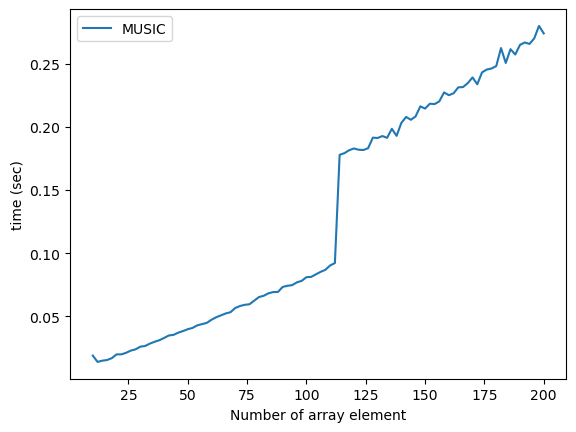

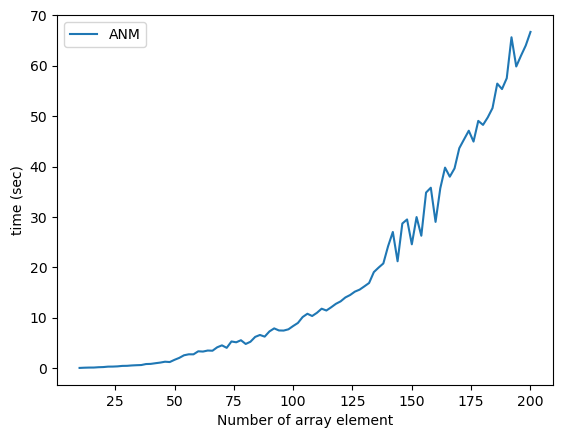

In [11]:
T1 = []
T2 = []
x = []
for k in range(96):
  x.append(10+2*k)
  t1, t2 = test_speed(1, 10+2*k, 5)
  T1.append(t1)
  T2.append(t2)
plt.xlabel("Number of array element")
plt.ylabel("time (sec)")
plt.plot(x, T1, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("Number of array element")
plt.ylabel("time (sec)")
plt.plot(x, T2, label = "ANM")
plt.legend()
plt.show()

MUSIC: 0.08613801002502441s
ANM: 10.198756217956543s
MUSIC: 0.08196663856506348s
ANM: 8.584223508834839s
MUSIC: 0.08281087875366211s
ANM: 9.31174635887146s
MUSIC: 0.08211803436279297s
ANM: 8.559947490692139s
MUSIC: 0.08390402793884277s
ANM: 8.407134056091309s
MUSIC: 0.08311867713928223s
ANM: 11.839439153671265s
MUSIC: 0.08428525924682617s
ANM: 11.928136587142944s
MUSIC: 0.08190202713012695s
ANM: 11.85740065574646s
MUSIC: 0.08406567573547363s
ANM: 12.669907331466675s
MUSIC: 0.08469128608703613s
ANM: 13.493782997131348s


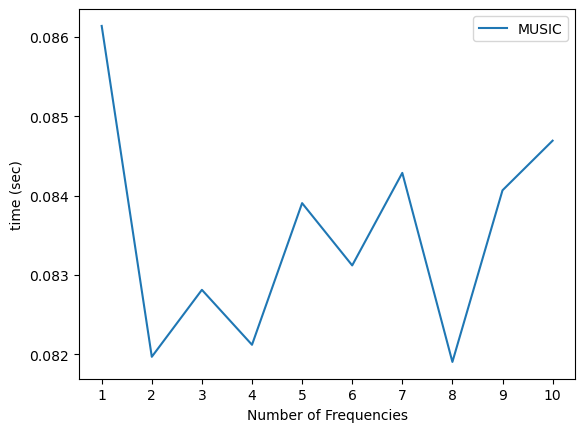

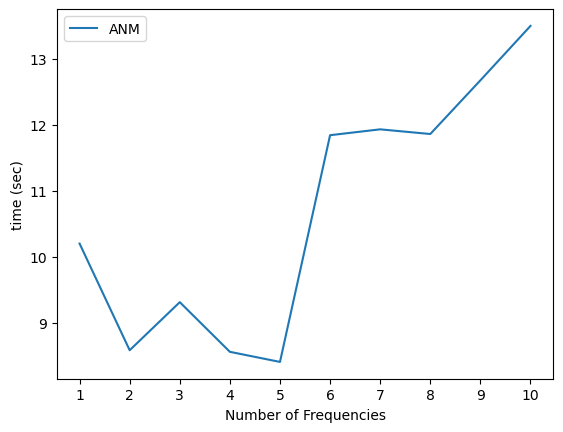

In [12]:
T1 = []
T2 = []
x = []
for k in range(10):
  numFreq = k+1
  x.append(numFreq)
  f = np.linspace(0,1-epsilon, numFreq)
  t1, t2 = test_speed(1, 100, freqs=f)
  T1.append(t1)
  T2.append(t2)
plt.xlabel("Number of Frequencies")
plt.xticks(x)
plt.ylabel("time (sec)")
plt.plot(x, T1, label = "MUSIC")
plt.legend()
plt.show()
plt.xlabel("Number of Frequencies")
plt.xticks(x)
plt.ylabel("time (sec)")
plt.plot(x, T2, label = "ANM")
plt.legend()
plt.show()